This notebook is a tutorial for training and prediction in data1.

# Load Dependencies

In [15]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import numpy as np
import pandas as pd
import tensorflow as tf
from rdkit import Chem
from script.MIGNN_model import Graph_DataLoader,MIGNN_model1
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import os 
os.environ["CUDA_DEVICE_ORDER"] = "1"

2023-02-20 20:39:02.094237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:39:02.094746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:39:02.095055: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/anaconda3/envs/SEMG/lib/python3.8/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause 

# Load Steric and Electronic Information

In [3]:
react_spms = np.load('./data1/run_data/data1_SEMG_MIGNN_react_spms.npy')
react_elec = np.load('./data1/run_data/data1_SEMG_MIGNN_react_elec.npy')
labels = np.load('./data1/run_data/data1_SEMG_MIGNN_labels.npy')
label_std = np.load('./data1/run_data/data1_SEMG_MIGNN_label_std.npy')

# Train model

## Interpolative Task

In [4]:
batch_size = 128
np.random.seed(2021)
shuffle = np.array(list(range(len(react_spms))))
np.random.shuffle(shuffle)
train_index = shuffle[:int(0.7*len(react_spms))]
val_index = shuffle[int(0.7*len(react_spms)):]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels[val_index]

spms_train_std=(spms_train-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
elec_train_std=(elec_train-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
spms_val_std=(spms_val-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
elec_val_std=(elec_val-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
y_train_std=(y_train-y_train.min())/(y_train.max()-y_train.min())
y_val_std=(y_val-y_train.min())/(y_train.max()-y_train.min())                                            
train_gen = Graph_DataLoader(spms_train,elec_train,y_train_std,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val_std,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()

/tmp/ipykernel_2123497/1514558296.py:10: RuntimeWarning: invalid value encountered in true_divide
  spms_train_std=(spms_train-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:11: RuntimeWarning: invalid value encountered in true_divide
  elec_train_std=(elec_train-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:12: RuntimeWarning: invalid value encountered in true_divide
  spms_val_std=(spms_val-spms_train.min(axis=0))/(spms_train.max(axis=0)-spms_train.min(axis=0))
/tmp/ipykernel_2123497/1514558296.py:13: RuntimeWarning: invalid value encountered in true_divide
  elec_val_std=(elec_val-elec_train.min(axis=0))/(elec_train.max(axis=0)-elec_train.min(axis=0))


In [5]:
model = MIGNN_model1(107, 36, 56, 18)

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 100
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_random.ckpt')
    print("model saved to %s" % path)  

2023-02-20 20:10:21.565192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:10:21.565429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:10:21.565603: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


22/22 [==============================] - 14s 461ms/step - loss: 0.0836 - val_loss: 0.0604
model saved to ./data1/run_data/data1_random.ckpt-1
22/22 [==============================] - 10s 432ms/step - loss: 0.0443 - val_loss: 0.0481
model saved to ./data1/run_data/data1_random.ckpt-2
22/22 [==============================] - 10s 437ms/step - loss: 0.0316 - val_loss: 0.0866
model saved to ./data1/run_data/data1_random.ckpt-3
22/22 [==============================] - 10s 435ms/step - loss: 0.0244 - val_loss: 0.1407
model saved to ./data1/run_data/data1_random.ckpt-4
22/22 [==============================] - 10s 434ms/step - loss: 0.0198 - val_loss: 0.2316
model saved to ./data1/run_data/data1_random.ckpt-5
22/22 [==============================] - 10s 434ms/step - loss: 0.0155 - val_loss: 0.1102
model saved to ./data1/run_data/data1_random.ckpt-6
22/22 [==============================] - 10s 434ms/step - loss: 0.0122 - val_loss: 0.0602
model saved to ./data1/run_data/data1_random.ckpt-7
22/22 

In [6]:
new_model = MIGNN_model1(107, 36, 56, 18)
opt = tf.keras.optimizers.Adam()
new_model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_random.ckpt-100') 
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=labels[val_index]
y_pred=y_pred*(y_train.max()-y_train.min())+y_train.min()
y_pred[np.where(y_pred<0)]=0

10/10 [==============================] - 2s 129ms/step


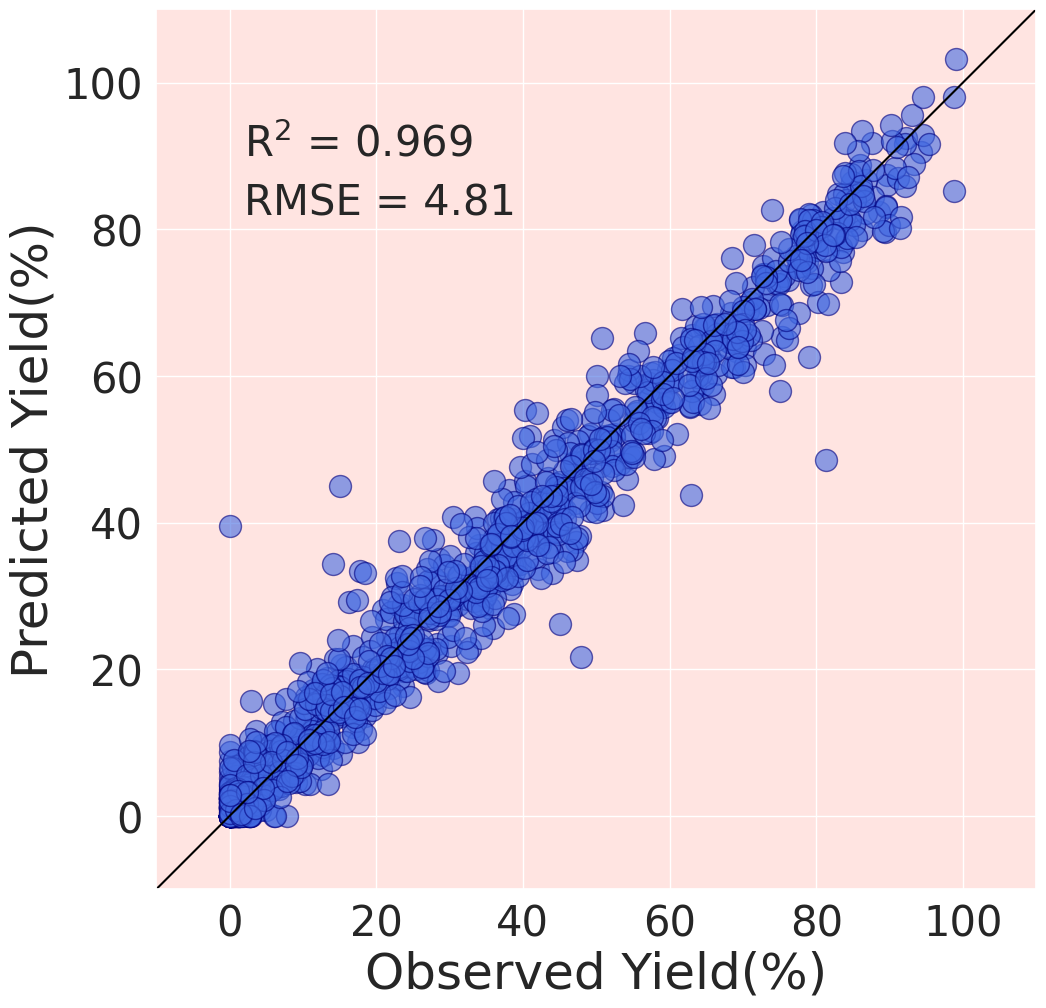

In [8]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',  
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)

plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()